In [2]:
import numpy as np
import scipy.constants
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime
import math
import h5py
import os
import bisect

import CDOconcat

from DREAM.DREAMOutput import DREAMOutput
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.animation import FuncAnimation
from IPython import display
plt.rcParams.update({'font.size': 16})
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['image.cmap'] = 'inferno'
#%matplotlib ipympl

def basic_1D(figsize=[8,4], ydata=None, xdata=None, ylabel=None, xlabel=None, 
             title=None, yscale="linear", ymin=None, ymax=None, savename=None,
             plotfoldername=None):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(xdata, ydata, drawstyle="steps-mid", linewidth=2)
    axes = plt.gca()
    axes.set_yscale(yscale)
    axes.set_ylim([ymin, ymax])
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    axes.grid()
    plt.title(title)
    
    if savename:
        now = datetime.datetime.now()
        date_time = now.strftime("_%Y-%m-%d_%Hh-%Mm-%Ss")
        plt.savefig(plotfoldername + savename + date_time + ".png", dpi=150)
        plt.close(fig)
    
        
def basic_2D(figsize=[8,4], xgrid=None, ygrid=None, savename=None, 
             title=None, cbarlabel=None, plotfoldername=None, ymin=None, ymax=None,
             normalization="lin", data=None, xlabel=None, ylabel=None,
             datamin=None, datamax=None, logdiff=None, levels=None, cmap=None):

    if datamax is None:
        datamax = data.max()
        
    if datamin is None:
        datamin = data.min()

    if levels is None:
        levels = 11
        
    if cmap is None:
        cmap = plt.colormaps['inferno']
        
    fig = plt.figure(figsize=figsize)
    
    if normalization == "log":
        if logdiff is None:
            ld = math.log10(datamax) - 1
            if ld > 10:
                logdiff = ld
            else:
                logdiff = 10
        
        logmax = math.ceil(np.log10(datamax))
        logmin = logmax - logdiff
        numofticks = logdiff
        div = logdiff // numofticks
        power = np.arange((logmax - (numofticks * div)), logmax, div)
        array = np.zeros(len(power)) + 10.
        ticks = np.power(array, power)
        levels1 = np.logspace(logmin, logmax, levels, base=10.0)
        formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
        norm = matplotlib.colors.LogNorm(vmin=10 ** (logmin), vmax=datamax)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)
        cbar = plt.colorbar(ticks=ticks, format=formatter)
        cbar.formatter = matplotlib.ticker.LogFormatterExponent(base=10)
        cbar.update_ticks()
    elif normalization == "lin":
        im = plt.contourf(xgrid, ygrid, data, levels=levels, cmap=cmap)
        cbar = plt.colorbar()
    else:
        print("\033[31mERROR:\033[m Not valid normalization (lin or log)\n")

    axes = plt.gca()
    axes.set_facecolor('black')
    cbar.set_label(cbarlabel)
    axes.set_ylim(ymin, ymax)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    if savename:
        now = datetime.datetime.now()
        date_time = now.strftime("_%Y-%m-%d_%Hh-%Mm-%Ss")
        plt.savefig(plotfoldername + savename + date_time + ".png", dpi=150)
        plt.close(fig)
    

def calculate_indices(timegrid, start, ms_step):
    i = bisect.bisect_left(timegrid, start)
    if i >= len(timegrid):
        i = len(timegrid) - 1
    elif i and timegrid[i] - start > start - timegrid[i - 1]:
        i = i - 1
    else:
        i = 0
        
    frames = []
    frames.append(i) 
    
    current_time = timegrid[i] + ms_step 
    j = i
    while i < len(timegrid):
        i = bisect.bisect_left(timegrid, current_time, lo=j)
        if i >= len(timegrid):
            i = len(timegrid) - 1
        elif i and timegrid[i] - current_time > current_time - timegrid[i - 1]:
            i = i - 1
            
        frames.append(i)
        current_time += ms_step
        j = i
        i += 1

    return frames

    
def update_RE(frame, *fargs):
    """
    fargs[0] - at_radial_cell
    fargs[1] - from_momentum_cell
    fagrs[2] - to_momentum_cell
    fargs[3] - data
    fargs[4] - axes
    fargs[5] - cbar
    """
    data_to_plot = fargs[3].f_re[frame, fargs[0], :, fargs[1]:fargs[2]]
    vmin = 1e7

    if data_to_plot.max() < 1e14:
        vmax = 1e14
    else:
        vmax = data_to_plot.max()
        
    axes = fargs[4]
    data = fargs[3]
    
    pcm = axes.pcolormesh(data.re_momentumgrid[fargs[1]:fargs[2]], 
                          data.re_pitchgrid_degrees, data_to_plot, 
                          norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                          cmap=plt.colormaps['inferno'])
    
    fargs[5].update_normal(pcm)
    axes.set_title("Momentum and pitch distribution of electrons\nt=" 
                   + '{0:.1f}'.format(np.round(data.timegrid_ms[frame], 1))
                   + "ms r=" + '{0:.3f}'.format(np.round(data.radialgrid[fargs[0]], 3)) + "m")
    
    return pcm,
    
    
def animate_RE(data, at_radial_cell, plotfoldername, from_time_ms=0, every_n_ms=5, 
              from_momentum_cell=0, to_momentum_cell=-1, figsize=[10, 5]):
    fig, axes = plt.subplots(figsize=figsize)
    pcm = axes.pcolormesh(np.zeros((2,2)), norm=colors.LogNorm(vmin=1e7, vmax=1e14), 
                          cmap=plt.colormaps['inferno'])
    
    axes.set_facecolor('black')
    axes.tick_params(axis='y', which='major', bottom=False)
    axes.set_xlim(data.re_momentumgrid[from_momentum_cell + 1], 
                  data.re_momentumgrid[to_momentum_cell])
    
    cbar = plt.colorbar(pcm, ax=axes, label=r"Electron distribution [1/m$^3$]")
    cbar.ax.minorticks_on()
    axes.set_ylabel(r"Pitch angle [degrees]")
    axes.set_xlabel(r"Momentum normalized to $m_ec$ [-]")
    axes.set_title("Momentum and pitch distribution of electrons\nt=" 
                   + "0ms r=" + '{0:.3f}'.format(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
    
    frames = calculate_indices(data.timegrid_ms, from_time_ms, every_n_ms)
    fargs = (at_radial_cell, from_momentum_cell, to_momentum_cell, data, axes, cbar)
    
    animation = FuncAnimation(fig, update_RE, frames=frames, fargs=fargs, 
                              interval=500, repeat_delay=1000, blit=True)
    
    video_path = "animation_" + '{0:.3f}'.format(np.round(data.radialgrid[at_radial_cell], 3)) + "m"
    while os.path.exists(plotfoldername + video_path + ".mp4"):
        video_path += "_alt"
        
    animation.save(plotfoldername + video_path + ".mp4", writer='ffmpeg')
    plt.close(fig)
    
    
def update_RE_avg(frame, *fargs):
    """
    fargs[0] - at_radial_cell
    fargs[1] - from_momentum_cell
    fagrs[2] - to_momentum_cell
    fargs[3] - data
    fargs[4] - axes
    """
    data_to_plot = fargs[3].f_re_avg[frame, fargs[0], fargs[1]:fargs[2]]
    
    if data_to_plot.max() < 1e14:
        vmax = 1e14
    else:
        vmax = data_to_plot.max()
        
    axes = fargs[4]
    data = fargs[3]
    
    line = fargs[5] 
    line.set_data(data.re_momentumgrid[fargs[1]:fargs[2]], data_to_plot)

    axes.set_title("Momentum and pitch distribution of electrons\nt=" 
                   + '{0:.1f}'.format(np.round(data.timegrid_ms[frame], 1))
                   + "ms r=" + '{0:.3f}'.format(np.round(data.radialgrid[fargs[0]], 3)) + "m")
    
    axes.set_ylim(1e7, vmax)
    
    return line,
    
    
def animate_RE_avg(data, at_radial_cell, plotfoldername, from_time_ms=0, every_n_ms=5, 
                   from_momentum_cell=0, to_momentum_cell=-1, figsize=[10, 5]):
    fig, axes = plt.subplots(figsize=figsize)
    line, = axes.plot([0, 1], [0, 1])
    
    axes.set_facecolor('white')
    # axes.tick_params(axis='y', which='major', bottom=False)
    axes.set_xlim(data.re_momentumgrid[from_momentum_cell + 1], 
                  data.re_momentumgrid[to_momentum_cell])
    
    axes.set_ylabel(r"Electron distribution [1/m$^3$]")
    axes.set_xlabel(r"Momentum normalized to $m_ec$ [-]")
    axes.set_title("Momentum distribution of electrons\nt=" 
                   + "0ms r=" + '{0:.3f}'.format(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
    axes.set_ylim(1e7, 1e14)
    axes.set_yscale("log")
    
    frames = calculate_indices(data.timegrid_ms, from_time_ms, every_n_ms)
    fargs = (at_radial_cell, from_momentum_cell, to_momentum_cell, data, axes, line)
    
    animation = FuncAnimation(fig, update_RE_avg, frames=frames, fargs=fargs, 
                              interval=500, repeat_delay=1000, blit=True)
    
    video_path = "angle_avg_" + '{0:.3f}'.format(np.round(data.radialgrid[at_radial_cell], 3)) + "m"
    while os.path.exists(plotfoldername + video_path + ".mp4"):
        video_path += "_alt"
        
    animation.save(plotfoldername + video_path + ".mp4", writer='ffmpeg')
    plt.close(fig)

    
def newest_output(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files if (basename.endswith('.h5') and basename.startswith('output_'))]
    return max(paths, key=os.path.getmtime)


def calculate_indices2(timegrid, start, number):
    i = bisect.bisect_left(timegrid, start)
    if i >= len(timegrid):
        i = len(timegrid) - 1
    elif i and timegrid[i] - start > start - timegrid[i - 1]:
        i = i - 1
    else:
        i = 0
        
    frames = []
    frames.append(i) 
    
    ms_step = (timegrid[-1] - timegrid[i]) / number
    current_time = timegrid[i] + ms_step 
    j = i
    while i < len(timegrid):
        i = bisect.bisect_left(timegrid, current_time, lo=j)
        if i >= len(timegrid):
            i = len(timegrid) - 1
        elif i and timegrid[i] - current_time > current_time - timegrid[i - 1]:
            i = i - 1
            
        frames.append(i)
        current_time += ms_step
        j = i
        i += 1

    return frames


In [3]:
folder = "C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/ndc3_30/"
diff = folder.split("/")[-2].split("_")[-1]

plotfoldername = folder + "plots/"
if os.path.exists(plotfoldername):
    pass
else:
    os.mkdir(plotfoldername)

animfoldername = folder + "vids/"
if os.path.exists(animfoldername):
    pass
else:
    os.mkdir(animfoldername)

fnames = []
try:
    newest = newest_output(folder)
    numoffiles = int(newest.split("_")[-2])
except:
    print("Finding newest output unsuccesful")
    
for i in range(1, numoffiles + 1):
    fname = folder + "output_" + str(i) + "_.h5"
    fnames.append(fname)
    
concat = CDOconcat.CustomConcat(fnames)
concat.info()

density_D_0 = concat.n_i[:, 0, :]
density_D_1 = concat.n_i[:, 1, :]
density_T_0 = concat.n_i[:, 2, :]
density_T_1 = concat.n_i[:, 3, :]
density_Ar = concat.n_i[:, 4:, :]

Simulation time from 0.001 ms to 175.1201 ms
Minor radius: [2.93] m
Number of radial grid cells: 20
Radial step (dr): 0.14650000000000002 m
Hottailgrid enabled: True
Resolution: (140, 1)
Runawaygrid enabled: True
Resolution: (240, 15)


In [4]:
current_threshold = 2e5
index = next(i for i,v in enumerate(concat.I_re) if v > current_threshold)
re_current_start_ms = concat.timegrid_ms[index]
from_time_ms = int(re_current_start_ms) - (int(re_current_start_ms) % 5)
print("RE current reaches 200 kA at: " + '{:.2f}'.format(re_current_start_ms) + " ms")
print("start animations from: " + str(from_time_ms) + " ms")

animations = True
figures = False

if figures:
    basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z0", 
             title="Deuterium density Z=0", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=150,
             normalization="log", data=density_D_0, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17)
    basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_Z1", 
             title="Deuterium density Z=1", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=150,
             normalization="log", data=density_D_1, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17)
    basic_2D(figsize=[6,4], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="deut_total", 
             title="Deuterium density Z=0, 1", cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=150,
             normalization="log", data=density_D_0 + density_D_1, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=17)
    
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="W_cold", 
             title="Cold electron energy density", cbarlabel=r"log$_{10}$(W$_{cold}$/(J/m$^3$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.W_cold, xlabel=None, ylabel=None,
             datamin=None, datamax=None, logdiff=5, levels=16)
    
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_tot", 
             title="Total current density", cbarlabel=r"log$_{10}$(j$_{tot}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.j_tot, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_re", 
             title="RE current density", cbarlabel=r"log$_{10}$(j$_{RE}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.j_re, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="j_ohm", 
             title="Ohmic current density", cbarlabel=r"log$_{10}$(j$_{ohm}$/(A/m$^2$)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.j_ohm, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)
    
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="T_cold_full", 
             title="Electron temperature", cbarlabel=r"log$_{10}$(T$_{cold}$/(1eV)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.T_cold, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=5, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="T_cold_zoomed", 
             title="Electron temperature", cbarlabel=r"log$_{10}$(T$_{cold}$/(1eV)) [-]", 
             plotfoldername=plotfoldername, ymax=75,
             normalization="log", data=concat.T_cold, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=5, levels=16)
    
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="E_field_lin", 
             title="Electric field", cbarlabel=r"E [V/m]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="lin", data=concat.E_field, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=3, levels=16)
    basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename="log_ratio_E_to_Eceff", 
             title=r"Logarithm of E/E$_{c, eff}$", cbarlabel=r"log$_{10}$(E/E$_{c, eff}$) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.E_field/concat.Eceff, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=2, levels=19, cmap=plt.colormaps['plasma'])
    
if True:
    fig = plt.figure(figsize=(8, 6))
    plt.subplot(1, 1, 1)  # rows, columns, index
    # For example fig.add_subplot(3, 1, (1, 2)) makes a subplot that spans the upper 2/3 of the figure

    plt.plot(concat.timegrid * 1000, concat.I_p / 1e6, label=r"I$_p$")
    plt.plot(concat.timegrid * 1000, (concat.I_re + concat.I_hot) / 1e6, label=r"I$_{RE}$")
    plt.plot(concat.timegrid * 1000, concat.I_wall / 1e6, label=r"I$_{wall}$")
    plt.plot(concat.timegrid * 1000,  concat.I_ohm / 1e6, linestyle="--", label=r"I$_{ohm}$")
    plt.plot(concat.timegrid * 1000,  concat.I_hot / 1e6, label=r"I$_{hot}$")

    plt.ylabel('Currents [MA]')
    plt.xlabel('Time [ms]')
    plt.title("D=" + diff + r" m$^2$/s; RE grid resolution " + str(concat.runawaygrid_dimensions) 
              + r"; p$_{max}$=" + '{0:.0f}'.format(np.round(concat.re_momentumgrid_edges[-1], 0)))
    plt.tick_params('x', labelbottom=True)

    plt.ylim(0, 18)
    plt.legend()
    plt.grid()

    savename = "currents_"
    savename += "diff_" + diff + "_REgrid_" + str(concat.runawaygrid_dimensions) + "_pMax_" 
    savename += '{0:.0f}'.format(np.round(concat.re_momentumgrid_edges[-1], 0))

    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)
    
if figures:
    indices = calculate_indices2(concat.timegrid_ms, from_time_ms + 20, 8)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.re_momentumgrid
    
    for r in range(len(concat.radialgrid)):
        ydata = concat.f_re_avg[:, r]
        fig = plt.figure(figsize=(8, 5))
        plt.subplot(1, 1, 1)  # rows, columns, index
        j = 0
        for i in indices:
            plt.plot(xdata, ydata[i], label='{0:.1f}'.format(np.round(concat.timegrid_ms[i], 1))+" ms", color=ccolors[j])
            j += 1

        plt.ylabel(r'Angle averaged distribution [m$^{-3}$]')
        plt.xlabel(r'p$_{||}$')
        plt.title("D=" + diff + r" m$^2$/s; resolution " + str(concat.runawaygrid_dimensions) 
                  + "; r=" + '{0:.3f}'.format(np.round(concat.radialgrid[r], 3)) + "m")
        plt.tick_params('x', labelbottom=True)

        plt.ylim(1e7, 1e14)
        plt.yscale("log")
        plt.legend()
        plt.grid()


        savename = ("f_re_avg_diff_" + diff + "_REgrid_" + str(concat.runawaygrid_dimensions) 
                    +"_r_" + '{0:.3f}'.format(np.round(concat.radialgrid[r], 3)) + "m")
        while os.path.exists(plotfoldername + savename + ".png"):
            savename += "_alt"

        plt.savefig(plotfoldername + savename + ".png", dpi=150)
        plt.close(fig)
        
if figures:
    indices = calculate_indices2(concat.timegrid_ms, from_time_ms + 20, 6)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.n_re
    fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.1f}'.format(np.round(concat.timegrid_ms[i], 1))+" ms", color=ccolors[j])
        j += 1

    plt.ylabel(r'Runaway electron density [m$^{-3}$]')
    plt.xlabel(r'Minor radius [m]')
    plt.title("D=" + diff + r" m$^2$/s; resolution " + str(concat.runawaygrid_dimensions))
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e14, None)
    plt.yscale("log")
    plt.legend()
    plt.grid()


    savename = ("n_re_" + diff + "_REgrid_" + str(concat.runawaygrid_dimensions))
    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)
    
if figures:
    indices = calculate_indices2(concat.timegrid_ms, 0, 8)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.radialgrid
    ydata = concat.j_tot
    fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, :], label='{0:.1f}'.format(np.round(concat.timegrid_ms[i], 1))+" ms", color=ccolors[j])
        j += 1

    plt.ylabel(r'Total current density [A/m$^{2}$]')
    plt.xlabel(r'Minor radius [m]')
    plt.title("D=" + diff + r" m$^2$/s; RE grid resolution " + str(concat.runawaygrid_dimensions))
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e4, None)
    plt.yscale("log")
    plt.legend()
    plt.grid()


    savename = ("j_tot_" + diff + "_REgrid_" + str(concat.runawaygrid_dimensions))
    while os.path.exists(plotfoldername + savename + ".png"):
        savename += "_alt"

    plt.savefig(plotfoldername + savename + ".png", dpi=150)
    plt.close(fig)
    
if animations:
    for i in range(len(concat.radialgrid)):
        animate_RE(concat, i, animfoldername, from_time_ms=from_time_ms, every_n_ms=5, 
                   from_momentum_cell=0, to_momentum_cell=-1, figsize=[10, 6])
        animate_RE_avg(concat, i, animfoldername, from_time_ms=from_time_ms, every_n_ms=5, 
                       from_momentum_cell=0, to_momentum_cell=-1, figsize=[10, 6])

RE current reaches 200 kA at: 43.65 ms
start animations from: 40 ms


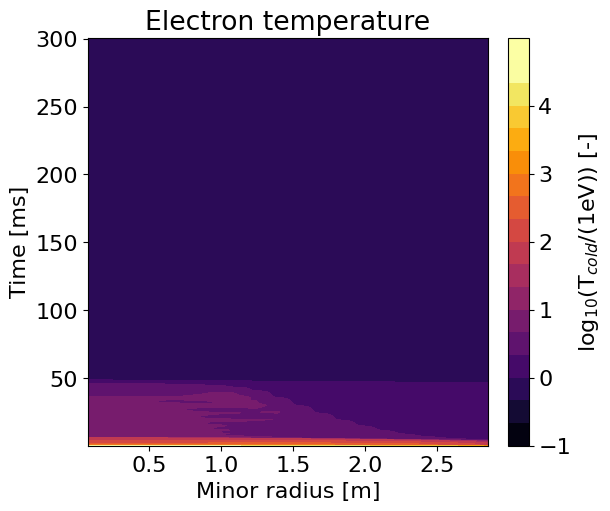

In [24]:
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
             title="Electron temperature", cbarlabel=r"log$_{10}$(T$_{cold}$/(1eV)) [-]", 
             plotfoldername=plotfoldername, ymax=None,
             normalization="log", data=concat.T_cold, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=6, levels=19)

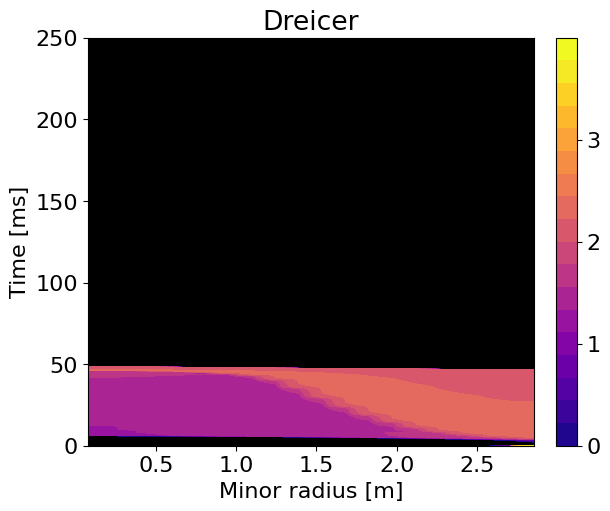

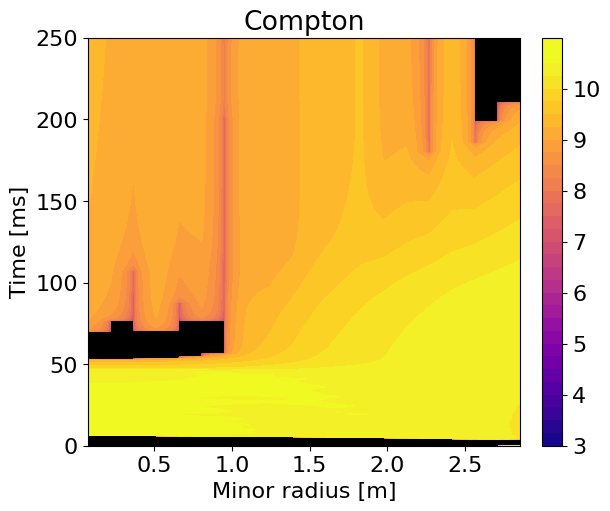

In [22]:
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
             title="Dreicer", cbarlabel=None, 
             plotfoldername=plotfoldername, ymin=0, ymax=250,
             normalization="log", data=concat.gammaDreicer, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=4, levels=19, cmap=plt.colormaps['plasma'])
basic_2D(figsize=[6,5], xgrid=concat.radialgrid, ygrid=concat.timegrid_ms, savename=None, 
             title="Compton", cbarlabel=None, 
             plotfoldername=plotfoldername, ymin=0, ymax=250,
             normalization="log", data=concat.gammaCompton, xlabel="Minor radius [m]", ylabel="Time [ms]",
             datamin=None, datamax=None, logdiff=8, levels=33, cmap=plt.colormaps['plasma'])